In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import json

from fycharts.SpotifyCharts import SpotifyCharts
import sqlalchemy

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller  

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

# Reading in data

In [2]:
italy_17_19 = pd.read_pickle('../data/it_17_19_v50_feat.pkl')
spain_17_19 = pd.read_pickle('../data/sp_17_19_v50_feat.pkl')
greece_17_19 = pd.read_pickle('../data/gr_17_19_v50_feat.pkl')

italy_20_21 = pd.read_pickle('../data/it_20_v50_feat.pkl')
spain_20_21 = pd.read_pickle('../data/sp_20_v50_feat.pkl')
greece_20_21 = pd.read_pickle('../data/gr_20_v50_feat.pkl')

In [4]:
spain_20_21.tail(2)

,Position,Track Name,Artist,region,spotify_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,,,,,
2021-02-13,49,La Luz - A COLORS SHOW,María José Llergo,es,5jRnVQbjB6qgN3MARS4xw7,0.722,0.357,9,-10.487,0,0.0996,0.81400,0.155000,0.0863,0.641,149.895,191599,4
2021-02-13,50,Boku no Sensou - TV Size,Shinsei Kamattechan,es,3tRPfCFAEv6wWyQO0YnGGV,0.447,0.891,9,-4.776,1,0.0788,0.00447,0.000905,0.3900,0.517,143.976,90960,4


# Preprocessing data 

#### _Data for each country is split into different dataframes as different combinations and aggregations are needed for different functions._ 

**Resampling by month**

_`rm` denotes resampling by month._ 

In [5]:
rm_italy_17_19 = italy_17_19.resample("M").mean()
rm_spain_17_19 = spain_17_19.resample("M").mean()
rm_greece_17_19 = greece_17_19.resample("M").mean()

rm_italy_20_21 = italy_20_21.resample("M").mean()
rm_spain_20_21 = spain_20_21.resample("M").mean()
rm_greece_20_21 = greece_20_21.resample("M").mean()

**Resampling by week**

_`rw` denotes resampling by week._ 

In [7]:
rw_italy_17_19 = italy_17_19.resample("W").mean()
rw_spain_17_19 = spain_17_19.resample("W").mean()
rw_greece_17_19 = greece_17_19.resample("W").mean()

rw_italy_20_21 = italy_20_21.resample("W").mean()
rw_spain_20_21 = spain_20_21.resample("W").mean()
rw_greece_20_21 = greece_20_21.resample("W").mean()

#### Combining weekly resampled data for all years (2017-2020)

In [8]:
alltime_italy = pd.concat([italy_17_19, italy_20_21])
alltime_spain = pd.concat([spain_17_19, spain_20_21])
alltime_greece = pd.concat([greece_17_19, greece_20_21])

alltime_rw_italy = alltime_italy.resample("W").mean()
alltime_rw_spain = alltime_spain.resample("W").mean()
alltime_rw_greece = alltime_greece.resample("W").mean()

#### Splitting into dataframes for each year! 

In [9]:
it_rw_17 = alltime_rw_italy[0:53]
it_rw_18 = alltime_rw_italy[53:105]
it_rw_20 = alltime_rw_italy[105:158]

In [10]:
rw_italy_20_21.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2021-02-07,25.5,0.666561,0.634389,5.402857,-6.677991,0.680000,0.109192,0.268234,0.035348,0.223654,0.498756,119.549403,195629.388571,3.951429
2021-02-14,25.5,0.671104,0.647343,5.516667,-6.842603,0.656667,0.120716,0.277941,0.054173,0.220087,0.548739,120.591240,194515.273333,3.913333


_Taking just the first 52 weeks of `rw_italy_20_21` so that it is only the weekly resampled Italy 2020 data._ 

In [11]:
it_rw_20 = rw_italy_20_21[0:53]
it_rw_20.tail()

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2020-12-06,25.514286,0.635391,0.586877,5.448571,-8.045040,0.534286,0.109029,0.332617,0.020756,0.174773,0.451704,120.883214,198297.631429,3.951429
2020-12-13,25.865714,0.658663,0.606386,5.334286,-7.434363,0.605714,0.097016,0.330153,0.019915,0.155027,0.480546,121.218346,198129.382857,3.945714
2020-12-20,25.771429,0.649389,0.601711,5.185714,-7.288403,0.617143,0.101651,0.337039,0.018042,0.157806,0.474697,117.303751,194437.685714,3.888571
2020-12-27,26.111429,0.658540,0.601163,5.225714,-7.301663,0.620000,0.099900,0.313663,0.036708,0.155573,0.494371,117.747651,190622.557143,3.894286
2021-01-03,25.948571,0.663151,0.618714,5.782857,-7.345991,0.582857,0.104829,0.309551,0.028036,0.173735,0.492659,115.925700,194482.251429,3.942857


# Differencing Data for Stationarity

### Augmented Dickey-Fuller test to estimate whether data are stationary. 

In [12]:
audio_features = [
'danceability', 
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [13]:
# Code by Joseph Nelson! 

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic', 'p-value', 'lags_used'])
    return dfoutput

_Dickey-Fuller on original dataframes_

In [14]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}:\n{interpret_dftest(adfuller(it_rw_20[feature]))}')

Dickey-Fuller Interpretation for danceability:
Test Statistic   -1.548511
p-value           0.509392
lags_used         7.000000
dtype: float64
Dickey-Fuller Interpretation for energy:
Test Statistic   -3.123421
p-value           0.024868
lags_used         0.000000
dtype: float64
Dickey-Fuller Interpretation for key:
Test Statistic   -3.427072
p-value           0.010070
lags_used         2.000000
dtype: float64
Dickey-Fuller Interpretation for loudness:
Test Statistic   -1.902387
p-value           0.330939
lags_used         7.000000
dtype: float64
Dickey-Fuller Interpretation for mode:
Test Statistic   -2.842559
p-value           0.052447
lags_used         0.000000
dtype: float64
Dickey-Fuller Interpretation for speechiness:
Test Statistic   -2.835576
p-value           0.053369
lags_used         0.000000
dtype: float64
Dickey-Fuller Interpretation for acousticness:
Test Statistic   -2.749330
p-value           0.065884
lags_used         0.000000
dtype: float64
Dickey-Fuller Interpretatio

### DataFrame with once-differenced data

In [15]:
lag_df_italy = alltime_rw_italy.copy()

In [16]:
for feature in audio_features: 
    lag_df_italy[f'{feature}_once_differenced'] = lag_df_italy[feature].diff(1).fillna(0)

In [17]:
lag_df_italy.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2021-02-07,25.5,0.666561,0.634389,5.402857,-6.677991,0.680000,0.109192,0.268234,0.035348,0.223654,...,0.029374,0.18000,0.314663,0.031429,-0.001159,-0.073344,-0.001695,0.005719,-0.006398,3.285271
2021-02-14,25.5,0.671104,0.647343,5.516667,-6.842603,0.656667,0.120716,0.277941,0.054173,0.220087,...,0.012955,0.11381,-0.164612,-0.023333,0.011523,0.009707,0.018826,-0.003567,0.049983,1.041837


_Dickey-Fuller on lag dataframe_

In [18]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}, once-differenced:\n{interpret_dftest(adfuller(lag_df_italy[feature].diff(1).fillna(0)))}')

Dickey-Fuller Interpretation for danceability, once-differenced:
Test Statistic   -9.142255e+00
p-value           2.828632e-15
lags_used         5.000000e+00
dtype: float64
Dickey-Fuller Interpretation for energy, once-differenced:
Test Statistic   -6.782611e+00
p-value           2.477455e-09
lags_used         7.000000e+00
dtype: float64
Dickey-Fuller Interpretation for key, once-differenced:
Test Statistic   -8.518281e+00
p-value           1.118537e-13
lags_used         7.000000e+00
dtype: float64
Dickey-Fuller Interpretation for loudness, once-differenced:
Test Statistic   -7.002232e+00
p-value           7.272028e-10
lags_used         6.000000e+00
dtype: float64
Dickey-Fuller Interpretation for mode, once-differenced:
Test Statistic   -9.845662e+00
p-value           4.627101e-17
lags_used         4.000000e+00
dtype: float64
Dickey-Fuller Interpretation for speechiness, once-differenced:
Test Statistic   -8.291616e+00
p-value           4.246658e-13
lags_used         5.000000e+00
dtype

_Checking that these are the same_

In [19]:
interpret_dftest(adfuller(lag_df_italy['tempo_once_differenced']))

Test Statistic   -6.454214e+00
p-value           1.497350e-08
lags_used         1.400000e+01
dtype: float64

In [20]:
interpret_dftest(adfuller(lag_df_italy['tempo'].diff(1).fillna(0)))

Test Statistic   -6.454214e+00
p-value           1.497350e-08
lags_used         1.400000e+01
dtype: float64

### Using `ndiffs` to figure out how many orders of difference $d$ I need in oder to have stationarity

#### _Running `ndiff` and `p,d,q` functions just on 2020 Italy data instead of alltime Italy data. Will use 2020 data to build the `ndiff_df` to see if this yields better results for this year._ 

In [21]:
from pmdarima.arima.utils import ndiffs

In [22]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(alltime_italy[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 0
ndiffs for energy stationarity w/ adf test: 0
ndiffs for key stationarity w/ adf test: 0
ndiffs for loudness stationarity w/ adf test: 0
ndiffs for mode stationarity w/ adf test: 0
ndiffs for speechiness stationarity w/ adf test: 0
ndiffs for acousticness stationarity w/ adf test: 0
ndiffs for instrumentalness stationarity w/ adf test: 0
ndiffs for liveness stationarity w/ adf test: 0
ndiffs for valence stationarity w/ adf test: 0
ndiffs for tempo stationarity w/ adf test: 0


In [23]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(alltime_rw_italy[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 1
ndiffs for energy stationarity w/ adf test: 0
ndiffs for key stationarity w/ adf test: 0
ndiffs for loudness stationarity w/ adf test: 0
ndiffs for mode stationarity w/ adf test: 1
ndiffs for speechiness stationarity w/ adf test: 0
ndiffs for acousticness stationarity w/ adf test: 0
ndiffs for instrumentalness stationarity w/ adf test: 0
ndiffs for liveness stationarity w/ adf test: 0
ndiffs for valence stationarity w/ adf test: 0
ndiffs for tempo stationarity w/ adf test: 0


In [24]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(it_rw_20[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 1
ndiffs for energy stationarity w/ adf test: 1
ndiffs for key stationarity w/ adf test: 0
ndiffs for loudness stationarity w/ adf test: 1
ndiffs for mode stationarity w/ adf test: 1
ndiffs for speechiness stationarity w/ adf test: 2
ndiffs for acousticness stationarity w/ adf test: 1
ndiffs for instrumentalness stationarity w/ adf test: 1
ndiffs for liveness stationarity w/ adf test: 1
ndiffs for valence stationarity w/ adf test: 1
ndiffs for tempo stationarity w/ adf test: 2


In [25]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(alltime_italy[feature])}')

ndiffs for danceability stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 1
ndiffs for key stationarity w/ kpss test: 1
ndiffs for loudness stationarity w/ kpss test: 1
ndiffs for mode stationarity w/ kpss test: 1
ndiffs for speechiness stationarity w/ kpss test: 1
ndiffs for acousticness stationarity w/ kpss test: 1
ndiffs for instrumentalness stationarity w/ kpss test: 1
ndiffs for liveness stationarity w/ kpss test: 1
ndiffs for valence stationarity w/ kpss test: 1
ndiffs for tempo stationarity w/ kpss test: 1


In [26]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(it_rw_20[feature])}')

ndiffs for danceability stationarity w/ kpss test: 0
ndiffs for energy stationarity w/ kpss test: 0
ndiffs for key stationarity w/ kpss test: 0
ndiffs for loudness stationarity w/ kpss test: 0
ndiffs for mode stationarity w/ kpss test: 0
ndiffs for speechiness stationarity w/ kpss test: 0
ndiffs for acousticness stationarity w/ kpss test: 0
ndiffs for instrumentalness stationarity w/ kpss test: 0
ndiffs for liveness stationarity w/ kpss test: 0
ndiffs for valence stationarity w/ kpss test: 0
ndiffs for tempo stationarity w/ kpss test: 0


### Finding `p`, `d`, and `q` values

_Using only the five audio features that are the most relevant or show some sort of pattern_ 

In [27]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'tempo']

_Building dataframe with `ndifffs` for stationarity for each feature_

_This time using `it_rw_20` instead of `alltime_rw_italy`._

In [58]:
ndiff_dict = {
    'audio_feature':[],
    'ndiffs for stationarity':[]    
}

for feature in five_features:
    ndiff_dict['audio_feature'].append(feature)
    ndiff_dict['ndiffs for stationarity'].append(ndiffs(it_rw_20[feature], test= "adf"))

ndiff_df = pd.DataFrame(ndiff_dict)
ndiff_df

,audio_feature,ndiffs for stationarity
0,danceability,1
1,mode,1
2,acousticness,1
3,valence,1
4,tempo,2


In [30]:
arima_dict_20 = {
    'audio_feature':[],
    'ndiffs(d)':[],
    'best_p':[],
    'best_q':[],
    'order':[],
    'ARIMA_model':[],
    'ARIMA_AIC':[]
}

def find_p_and_q(df, feature, arima_dict, n=6):
    
    train = df[feature][0:162]
    
    d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]

    # starting with large start AIC
    best_aic = 99 * (10 * 16)
    # creating variables to store best values ofd p and q 
    best_p = 0
    best_q = 0 

    # use nested for loop to iterate over values of p and q
    for p in range(n):

        for q in range(n):

            # insert try and and except statements
            try: 

                # fitting on ARIMA(p, 1, q) model 
                print(f'Attempting to fit ARIMA({p}, {d}, {q})')

                # instantiate ARIMA model
                arima = ARIMA(train, order=(p,d,q))

                # fit ARIMA model 
                model = arima.fit()

                # print out AIC for ARIMA(p, 1, q) model 
                print(f'For {feature}, the AIC for ARIMA({p},{d},{q}) is: {model.aic}')

                # Is this current model's AIC better than the OF best_aic? 
                if model.aic < best_aic:
                    # we want aic to be lower so we are setting a high aic and hoping for something lower 

                    # if it is, we overwrite the best_aic, best_p, and best_q
                    best_aic = model.aic
                    best_p = p 
                    best_q = q

            except:
                pass 

        order = (best_p, d, best_q)
    
    arima_dict['audio_feature'].append(feature)
    arima_dict['ndiffs(d)'].append(d)
    arima_dict['best_p'].append(best_p)
    arima_dict['best_q'].append(best_q)
    arima_dict['order'].append(order)
    arima_dict['ARIMA_model'].append(f'ARIMA({best_p},{d},{best_q})')
    arima_dict['ARIMA_AIC'].append(best_aic)

    print()
    print(f'{feature.upper()} MODEL FINISHED!')
    print(f'The model for {feature} that minimizes AIC on the training data is the ARIMA({best_p},{d},{best_q}).')
    print(f'The model has an aIC of {best_aic}.')
    print()

In [31]:
arima_dict_20

{'audio_feature': [],
 'ndiffs(d)': [],
 'best_p': [],
 'best_q': [],
 'order': [],
 'ARIMA_model': [],
 'ARIMA_AIC': []}

In [32]:
for feature in five_features:
    find_p_and_q(it_rw_20, feature, arima_dict_20)

Attempting to fit ARIMA(0, 1, 0)
For danceability, the AIC for ARIMA(0,1,0) is: -205.5523299668606
Attempting to fit ARIMA(0, 1, 1)
For danceability, the AIC for ARIMA(0,1,1) is: -203.74405596228323
Attempting to fit ARIMA(0, 1, 2)
For danceability, the AIC for ARIMA(0,1,2) is: -212.63140194111244
Attempting to fit ARIMA(0, 1, 3)
For danceability, the AIC for ARIMA(0,1,3) is: -210.94128126103553
Attempting to fit ARIMA(0, 1, 4)
For danceability, the AIC for ARIMA(0,1,4) is: -209.066631272423
Attempting to fit ARIMA(0, 1, 5)
For danceability, the AIC for ARIMA(0,1,5) is: -209.4958601921778
Attempting to fit ARIMA(1, 1, 0)
For danceability, the AIC for ARIMA(1,1,0) is: -203.61921470158663
Attempting to fit ARIMA(1, 1, 1)
For danceability, the AIC for ARIMA(1,1,1) is: -210.0806742468661
Attempting to fit ARIMA(1, 1, 2)
For danceability, the AIC for ARIMA(1,1,2) is: -210.8656674410963
Attempting to fit ARIMA(1, 1, 3)
For danceability, the AIC for ARIMA(1,1,3) is: -208.94417058490572
Attemp

In [33]:
arima_param_df_20 = pd.DataFrame(arima_dict_20)
arima_param_df_20

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC
0,danceability,1,2,2,"(2, 1, 2)","ARIMA(2,1,2)",-214.352402
1,mode,1,4,0,"(4, 1, 0)","ARIMA(4,1,0)",-187.656554
2,acousticness,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-170.836344
3,valence,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-208.242293
4,tempo,2,0,1,"(0, 2, 1)","ARIMA(0,2,1)",235.399507


# ARIMA Models  

### Function to create, evaluate, and plot `ARIMA` models 

In [34]:
def arima_predict_plot(df, feature, year, param_df, title='title', figsize=(15,5), order=None, d=None, ci=True):
  
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    if order is None:
        # find order from arima parameters dataframe 
        order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
   
    try: 
        # instantiate ARIMA model
        model = ARIMA(train, order=order)

        # fit ARIMA model
        arima = model.fit()

        # get predictions for train and test sets 
        preds_train = model.predict(params=arima.params, start=train.index[d], end=train.index[-1], typ='levels')
        preds_test = model.predict(params=arima.params, start=test.index[0], end=test.index[-1], typ='levels')

        # calculate and print RMSE for train and test setes 
        train_rmse = mean_squared_error(train[d::], preds_train)**0.5
        print(f'{feature.capitalize()} train RMSE ({year}) - ARIMA({order}): {train_rmse}')

        test_rmse = mean_squared_error(test, preds_test)**0.5
        print(f'{feature.capitalize()} test RMSE ({year}) - ARIMA({order}): {test_rmse}')

        # add RMSEs to arima parameters dataframe 
        param_df.loc[param_df['audio_feature'] == feature, 'arima_train_rmse'] = train_rmse    
        param_df.loc[param_df['audio_feature'] == feature, 'arima_test_rmse'] = test_rmse

          # set up plot
        plt.figure(figsize=figsize)

        # plot training data 
        plt.plot(train, color='blue')

        # plot testing data 
        plt.plot(test.index, test, color='orange')

        # plot predicted values for test set 
        plt.plot(test.index, preds_test, color='green')

        # add line for the baseline model (mean value of feature)
        plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')

        # plot confidence interval
        if ci:
            ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
            plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

        # make plot with title! 
        plt.title(title, fontsize=16)
        plt.show() ; 
        
    except:
        print(ValueError)
        pass

In [122]:
import pickle

In [124]:
pwd

'/Users/emilynaftalin/Data_Science/General Assembly/dsi/capstone/code'

In [123]:
app = pickle.dumps(arima_predict_plot)

In [125]:
app

b'\x80\x04\x95#\x00\x00\x00\x00\x00\x00\x00\x8c\x08__main__\x94\x8c\x12arima_predict_plot\x94\x93\x94.'

In [126]:
type(app)

bytes

In [127]:
ar_imp = pickle.loads(app)

In [130]:
type(ar_imp)

function

_Function soley for plotting to be used when needed._

In [35]:
def arima_plot(train, test, preds_test, title='title', figsize=(15,5), ci=True):
    
    # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # add line for the baseline model (mean value of feature)
    # plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')
    
    # plot confidence interval 
    if ci:
        ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
        plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 
    
    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

### ARIMA Models - 2020

_Using `arima_predict_plot` function to run ARIMA model for each feature and show plot of actual vs. test._

_This will also add columns for `arima_train_rmse` and `arima_test_rmse`._

In [36]:
it_rw_20.head(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2020-01-05,25.5,0.696228,0.645564,6.336,-6.606992,0.628000,0.128064,0.228294,0.030112,0.183885,0.474768,119.054180,189219.892000,3.960000
2020-01-12,25.5,0.668417,0.639666,5.720,-6.622551,0.611429,0.126540,0.231547,0.032838,0.172342,0.445104,119.640874,189433.622857,3.945714


In [37]:
it_rw_20.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2020-12-27,26.111429,0.658540,0.601163,5.225714,-7.301663,0.620000,0.099900,0.313663,0.036708,0.155573,0.494371,117.747651,190622.557143,3.894286
2021-01-03,25.948571,0.663151,0.618714,5.782857,-7.345991,0.582857,0.104829,0.309551,0.028036,0.173735,0.492659,115.925700,194482.251429,3.942857


d = 1
order = (2, 1, 2)
Danceability train RMSE (2020) - ARIMA((2, 1, 2)): 0.02995457600968979
Danceability test RMSE (2020) - ARIMA((2, 1, 2)): 0.031795124603817455


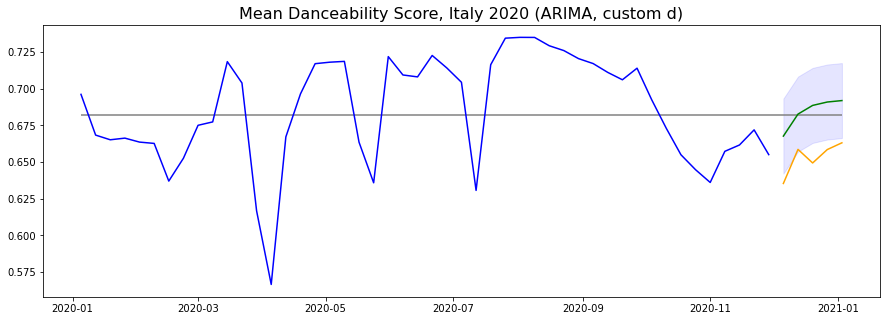

d = 1
order = (4, 1, 0)
Mode train RMSE (2020) - ARIMA((4, 1, 0)): 0.036004276661332824
Mode test RMSE (2020) - ARIMA((4, 1, 0)): 0.05415778931423301


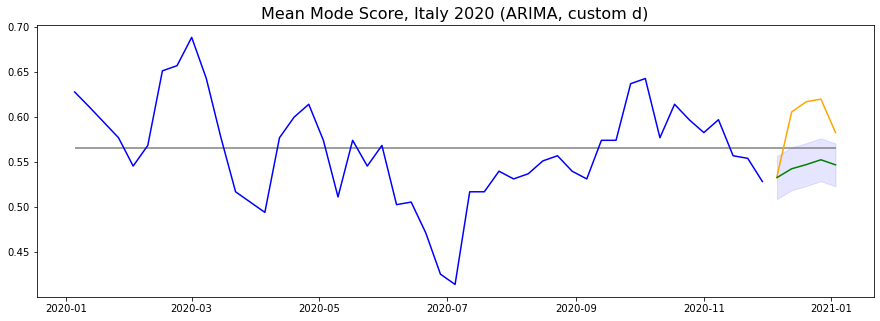

d = 1
order = (1, 1, 1)
Acousticness train RMSE (2020) - ARIMA((1, 1, 1)): 0.0449079068196806
Acousticness test RMSE (2020) - ARIMA((1, 1, 1)): 0.03127249902226224


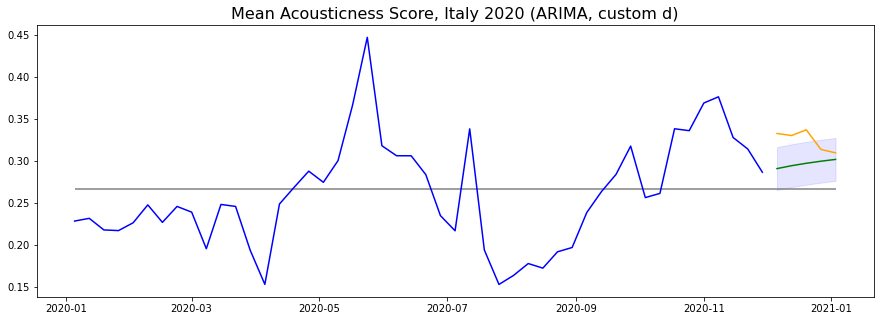

d = 1
order = (0, 1, 0)
Valence train RMSE (2020) - ARIMA((0, 1, 0)): 0.032649397834744937
Valence test RMSE (2020) - ARIMA((0, 1, 0)): 0.02714817888315545


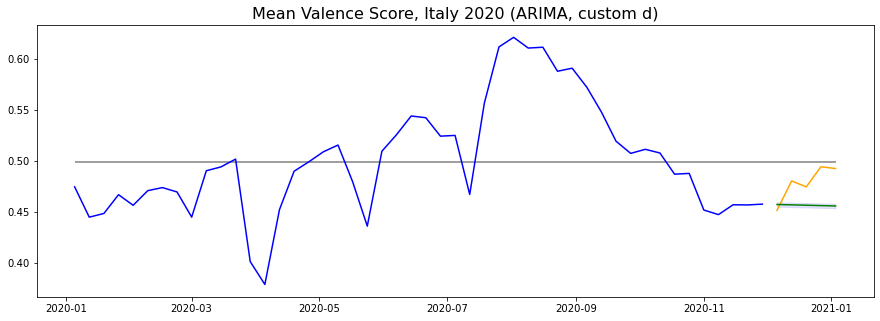

d = 2
order = (0, 2, 1)
Tempo train RMSE (2020) - ARIMA((0, 2, 1)): 2.298025149765302
Tempo test RMSE (2020) - ARIMA((0, 2, 1)): 1.9326112455837707


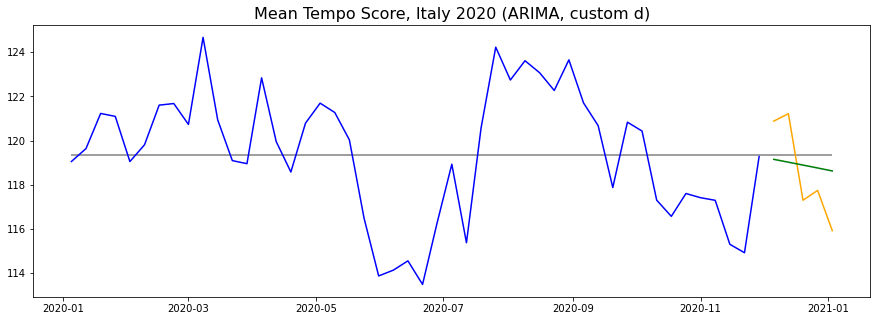

In [38]:
for feature in five_features: 
    arima_predict_plot(it_rw_20, feature, 2020, arima_param_df_20, title=f'Mean {feature.capitalize()} Score, Italy 2020 (ARIMA, custom d)')

#### _Updated `arima_param_df_20`_

In [39]:
arima_param_df_20

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse
0,danceability,1,2,2,"(2, 1, 2)","ARIMA(2,1,2)",-214.352402,0.029955,0.031795
1,mode,1,4,0,"(4, 1, 0)","ARIMA(4,1,0)",-187.656554,0.036004,0.054158
2,acousticness,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-170.836344,0.044908,0.031272
3,valence,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-208.242293,0.032649,0.027148
4,tempo,2,0,1,"(0, 2, 1)","ARIMA(0,2,1)",235.399507,2.298025,1.932611


# SARIMAX models 

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### _As baseline, Fitting SARIMAX with `seasonal_order = (2, 0, 2, 52)` and no exogenous variables before incorporating/engineering those components._

RMSE = 0.03


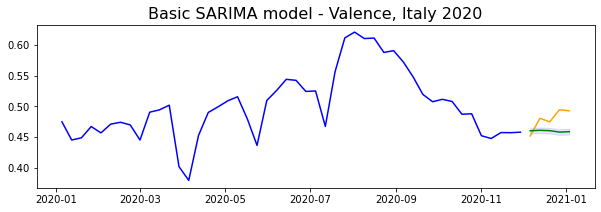

In [41]:
P, D, Q, S = 2, 0 ,2, 52
train_val = it_rw_20['valence'][0:48]
test_val = it_rw_20['valence'][48:]

sarima_val = SARIMAX(endog = train_val, order = (2, 0, 2), seasonal_order = (P, D, Q, S)).fit()
# sarima_pred = sarima.predict(start=start, end = end)

preds_train_sarima_val = sarima_val.predict(start=train_val.index[0], end=train_val.index[-1])
preds_test_sarima_val = sarima_val.predict(start=test_val.index[0], end=test_val.index[-1])

print(f'RMSE = {round(mean_squared_error(test_val, preds_test_sarima_val)**.5, 2)}')

arima_plot(train_val, test_val, preds_test_sarima_val, title="Basic SARIMA model - Valence, Italy 2020", figsize=(10,3))

#### Plotting ARIMA plot from above again, for comparison: 

d = 1
order = (2, 1, 2)
Valence train RMSE (2020) - ARIMA((2, 1, 2)): 0.036157040161561356
Valence test RMSE (2020) - ARIMA((2, 1, 2)): 0.04017210751841029


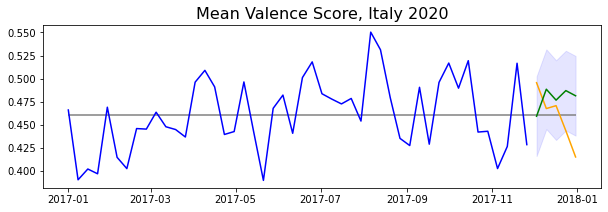

In [43]:
arima_predict_plot(it_rw_17, 'valence', 2020, arima_param_df_20, title=f'Mean Valence Score, Italy 2020', figsize=(10,3), order=(2,1,2))

### SARIMAX Seasonal Parameters

#### _Grid search to find best `P`, `D`, `Q`, and `s` values_

In [44]:
def find_sarima_parameters(df, feature, param_df, n_rows=47):    
    
    import time
    t0 = time.time()
    final_mae = 1000000000000
    final_S = 0
    final_D = 0
    final_P = 0
    final_Q = 0
    
    # find order from arima parameters dataframe 
    order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]

    train_values = df[feature][0:n_rows]
    test_values = df[feature][n_rows:]

    for S in range(48,53):
        for D in range(2):
            for P in range(4):
                for Q in range(4):
                    print(f'Checking ({P}, {D}, {Q}, {S}) at {round(time.time() - t0)} seconds.')
                    try:
                        sarima = SARIMAX(endog = train_values,
                                         order = order,
                                         seasonal_order = (P, D, Q, S)).fit()

                        sarima_pred = sarima.predict(start=test_values.index[0], end=test_values.index[-1], typ='levels')

                        if mean_absolute_error(test_values, sarima_pred) < final_mae:
                            final_mae = mean_absolute_error(test_values, sarima_pred)
                            final_S = S
                            final_D = D
                            final_P = P
                            final_Q = Q

                        print(f'We just fit a SARIMAX(2, 0, 2)x({P}, {D}, {Q}, {S}) model with {mean_absolute_error(test_values, sarima_pred)} MAE and {mean_squared_error(test_values, sarima_pred)**0.5} RMSE.')

                    except:
                        print('problem!')
                        raise

    print()
    print(f'The final model for {feature} is SARIMAX(2, 0, 2)x({final_P}, {final_D}, {final_Q}, {final_S}).')
    print()

In [45]:
five_features

['danceability', 'mode', 'acousticness', 'valence', 'tempo']

In [46]:
for feature in five_features: 
    find_sarima_parameters(it_rw_20, feature, arima_param_df_20)

Checking (0, 0, 0, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 0, 48) model with 0.030985734375650442 MAE and 0.03210632538838344 RMSE.
Checking (0, 0, 1, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 1, 48) model with 0.03441740062262031 MAE and 0.03518666044932518 RMSE.
Checking (0, 0, 2, 48) at 2 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 2, 48) model with 0.03414021870293752 MAE and 0.0348973148567914 RMSE.
Checking (0, 0, 3, 48) at 10 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 3, 48) model with 0.03493866960791775 MAE and 0.0357067853220159 RMSE.
Checking (1, 0, 0, 48) at 46 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 0, 48) model with 0.033643718952868086 MAE and 0.034419782146367345 RMSE.
Checking (1, 0, 1, 48) at 48 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 1, 48) model with 0.0350761616039588 MAE and 0.035784758948034026 RMSE.
Checking (1, 0, 2, 48) at 50 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 2, 48) model with 0.037951489122647196

LinAlgError: Schur decomposition solver error.

Encounted `linalgerror` while trying to run `find_sarima_parameters` on 2020 Italy data (`it_rw_20`). It did run for danceability, mode, and acousticness, and the `seasonal_order` output was similar to that which I found for the 2017. I will therefore use the same `seasonal_order` for each the audio as was determined by the 2017 data (`it_rw_17). 

Results for the above for 2017 data:
+ The final model for danceability is SARIMAX(2, 0, 2)x(3, 0, 0, 48).
+ The final model for mode is SARIMAX(2, 0, 2)x(1, 0, 1, 52).
+ The final model for acousticness is SARIMAX(2, 0, 2)x(1, 0, 2, 48).
+ The final model for valence is SARIMAX(2, 0, 2)x(0, 0, 1, 49).
+ The final model for tempo is SARIMAX(2, 0, 2)x(2, 0, 0, 49).

#### _Adding Seasonal Orders to `param_df`_

citation: converting string to tuple https://www.geeksforgeeks.org/python-convert-string-to-tuple/

In [48]:
arima_param_df_20.loc[arima_param_df_20['audio_feature'] == 'danceability', 'seasonal_order'] = '3, 0, 0, 48'
arima_param_df_20.loc[arima_param_df_20['audio_feature'] == 'mode', 'seasonal_order'] = '1, 0, 1, 52'
arima_param_df_20.loc[arima_param_df_20['audio_feature'] == 'acousticness', 'seasonal_order'] = '1, 0, 2, 48'
arima_param_df_20.loc[arima_param_df_20['audio_feature'] == 'valence', 'seasonal_order'] = '0, 0, 1, 49'
arima_param_df_20.loc[arima_param_df_20['audio_feature'] == 'tempo', 'seasonal_order'] = '2, 0, 0, 49'

#### _Updated `arima_param_df_20`_

In [49]:
arima_param_df_20

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order
0,danceability,1,2,2,"(2, 1, 2)","ARIMA(2,1,2)",-214.352402,0.029955,0.031795,"3, 0, 0, 48"
1,mode,1,4,0,"(4, 1, 0)","ARIMA(4,1,0)",-187.656554,0.036004,0.054158,"1, 0, 1, 52"
2,acousticness,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-170.836344,0.044908,0.031272,"1, 0, 2, 48"
3,valence,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-208.242293,0.036157,0.040172,"0, 0, 1, 49"
4,tempo,2,0,1,"(0, 2, 1)","ARIMA(0,2,1)",235.399507,2.298025,1.932611,"2, 0, 0, 49"


#### _Function for SARIMA w/ seasonal components, no exogenous variables:_

In [97]:
def sarima_predict_plot_seasonal(df, feature, year, param_df, title='title', figsize=(15,5), order=None, d=None, seasonal_order=None, ci=True):
  
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    # find order from arima parameters dataframe 
    if order is None:
        order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
    
    # find seasonal order from arima parameters dataframe 
    if seasonal_order is None: 
        sea_string = param_df.loc[param_df['audio_feature'] == feature, 'seasonal_order'].iloc[0]
        seasonal_order = tuple(map(int, sea_string.split(', '))) 
    print(f'seasonal order = {seasonal_order}')
    
    try: 

        # instantiate and fit SARIMAX model 
        sarima = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order).fit()

        # get predictions for train and test sets 
        preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels')
        preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels')

        # calculate and print RMSE for train and test setes 
        train_rmse = mean_squared_error(train[d::], preds_train)**0.5
        print(f'{feature.capitalize()} train RMSE ({year}) - SARIMA({order}): {train_rmse}')

        test_rmse = mean_squared_error(test, preds_test)**0.5
        print(f'{feature.capitalize()} test RMSE ({year}) - SARIMA({order}): {test_rmse}')    

        # add RMSEs to arima parameters dataframe 
        param_df.loc[param_df['audio_feature'] == feature, 'sarima_train_rmse'] = train_rmse    
        param_df.loc[param_df['audio_feature'] == feature, 'sarima_test_rmse'] = test_rmse

        # calculate residuals
        # residuals = test - preds_test

        # set up plot
        plt.figure(figsize=figsize)

        # plot training data 
        plt.plot(train, color='blue')

        # plot testing data 
        plt.plot(test.index, test, color='orange')

        # plot predicted values for test set 
        plt.plot(test.index, preds_test, color='green')

        # add line for the baseline model (mean value of feature)
        plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')

        # plot confidence interval 
        if ci:
            ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
            plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

        # make plot with title! 
        plt.title(title, fontsize=16)
        plt.show() ; 
        
    
    except ValueError as ve:
        print(ve)
        pass

In [98]:
# del sarima_predict_plot_seasonal

# from custom_functions import sarima_predict_plot_seasonal

# sarima_predict_plot_seasonal()

d = 1
order = (2, 1, 2)
seasonal order = (3, 0, 0, 48)
Danceability train RMSE (2020) - SARIMA((2, 1, 2)): 0.02915459822793162
Danceability test RMSE (2020) - SARIMA((2, 1, 2)): 0.006303117521742297


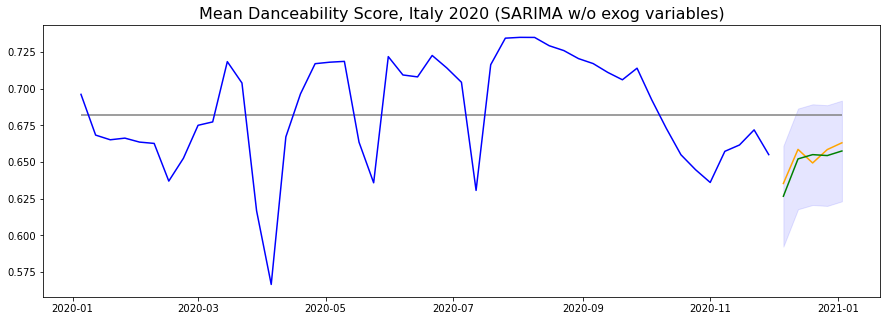

d = 1
order = (4, 1, 0)
seasonal order = (1, 0, 1, 52)
Mode train RMSE (2020) - SARIMA((4, 1, 0)): 0.03603351565623452
Mode test RMSE (2020) - SARIMA((4, 1, 0)): 0.04697784415249299


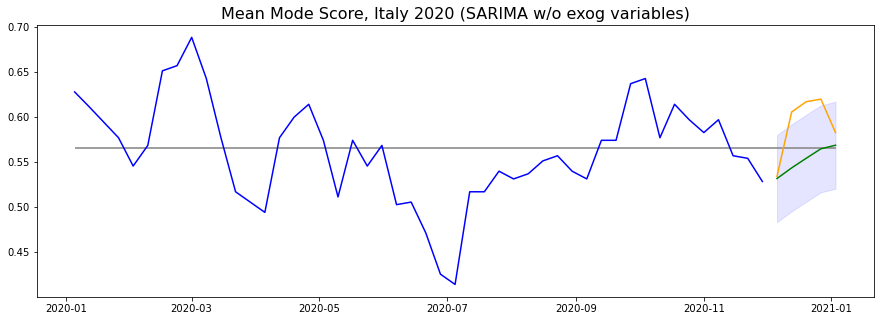

d = 1
order = (1, 1, 1)
seasonal order = (1, 0, 2, 48)
Acousticness train RMSE (2020) - SARIMA((1, 1, 1)): 0.04534937818196601
Acousticness test RMSE (2020) - SARIMA((1, 1, 1)): 0.035443555395954895


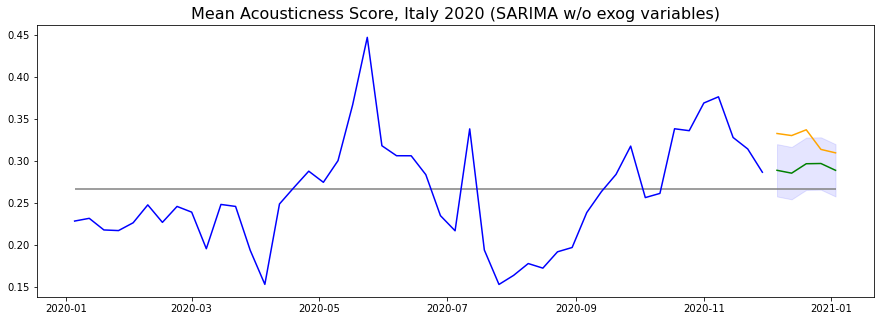

d = 1
order = (0, 1, 0)
seasonal order = (0, 0, 1, 49)
Valence train RMSE (2020) - SARIMA((0, 1, 0)): 0.03265138269391177
Valence test RMSE (2020) - SARIMA((0, 1, 0)): 0.02601077093217354


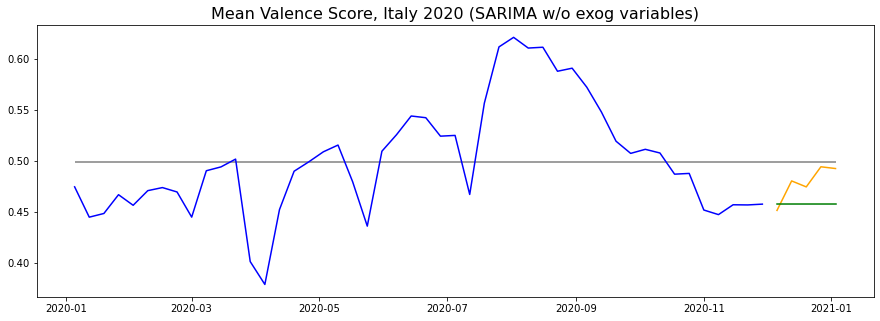

d = 2
order = (0, 2, 1)
seasonal order = (2, 0, 0, 49)
Tempo train RMSE (2020) - SARIMA((0, 2, 1)): 2.2981562176620454
Tempo test RMSE (2020) - SARIMA((0, 2, 1)): 2.2778147417313175


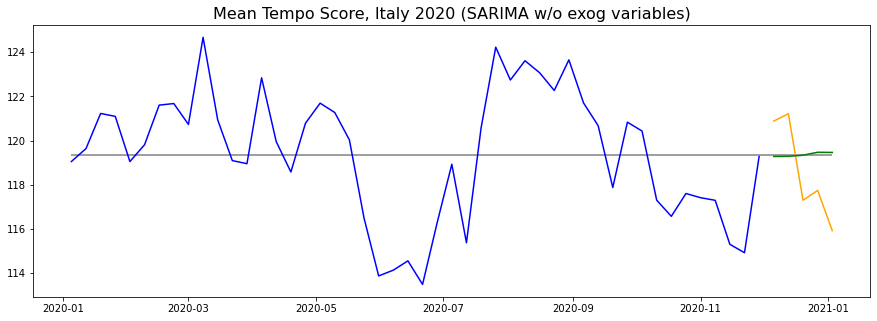

In [110]:
for feature in five_features:
    sarima_predict_plot_seasonal(it_rw_20, feature, 2020, arima_param_df_20, title=f'Mean {feature.capitalize()} Score, Italy 2020 (SARIMA w/o exog variables)')

#### _Updated `arima_param_df_20`_

In [111]:
arima_param_df_20

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,sarima_train_rmse,sarima_test_rmse,exog_train_rmse,exog_test_rmse
0,danceability,1,2,2,"(2, 1, 2)","ARIMA(2,1,2)",-214.352402,0.029955,0.031795,"3, 0, 0, 48",0.029155,0.006303,0.017313,0.026653
1,mode,1,4,0,"(4, 1, 0)","ARIMA(4,1,0)",-187.656554,0.036004,0.054158,"1, 0, 1, 52",0.036034,0.046978,0.031877,0.050937
2,acousticness,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-170.836344,0.044908,0.031272,"1, 0, 2, 48",0.045349,0.035444,0.034245,0.035041
3,valence,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-208.242293,0.036157,0.040172,"0, 0, 1, 49",0.032651,0.026011,0.016684,0.031002
4,tempo,2,0,1,"(0, 2, 1)","ARIMA(0,2,1)",235.399507,2.298025,1.932611,"2, 0, 0, 49",2.298156,2.277815,1.831272,2.867787


#### _Incorporating Exogenous Variables in SARIMAX models_

In [112]:
def sarima_predict_plot_exog(df, feature, year, param_df, exog_var, title='title', figsize=(15,5), order=None, d=None, seasonal_order=None, ci=True):

    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    # find order from arima parameters dataframe 
    if order is None:
        order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
    
    # find seasonal order from arima parameters dataframe 
    if seasonal_order is None: 
        sea_string = param_df.loc[param_df['audio_feature'] == feature, 'seasonal_order'].iloc[0]
        seasonal_order = tuple(map(int, sea_string.split(', '))) 
    print(f'seasonal order = {seasonal_order}')
    
    # reshape exogenous features to pass to the model 
    exog = df.loc[:, exog_var]   
   
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
  
    try:
        # instantiate and fit SARIMAX model 
        sarima = SARIMAX(endog=train, exog=exog[0:n_rows], order=order, seasonal_order=seasonal_order).fit()

        # get predictions for train and test sets 
        preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels', exog=exog[0:n_rows])
        preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels', exog=exog[n_rows:])

        # calculate and print RMSE for train and test setes 
        train_rmse = mean_squared_error(train[d::], preds_train)**0.5
        print(f'{feature.capitalize()} train RMSE ({year}) - SARIMAX({seasonal_order}) w/ exogenous variables: {train_rmse}')

        test_rmse = mean_squared_error(test, preds_test)**0.5
        print(f'{feature.capitalize()} test RMSE ({year}) - SARIMAX({seasonal_order}) w/ exogenous variables: {test_rmse}')    

        # add RMSEs to arima parameters dataframe 
        param_df.loc[param_df['audio_feature'] == feature, 'exog_train_rmse'] = train_rmse    
        param_df.loc[param_df['audio_feature'] == feature, 'exog_test_rmse'] = test_rmse

        # calculate residuals
        # residuals = test - preds_test

        # set up plot
        plt.figure(figsize=figsize)

        # plot training data 
        plt.plot(train, color='blue')

        # plot testing data 
        plt.plot(test.index, test, color='orange')

        # plot predicted values for test set 
        plt.plot(test.index, preds_test, color='green')

        # add line for the baseline model (mean value of feature)
        plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')

        # plot confidence interval 
        if ci:
            ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
            plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

        # make plot with title! 
        plt.title(title, fontsize=16)
        plt.show() ; 
        
    except ValueError as ve:
        print(ve)
        pass

_Identifying exogenous variables for each of the five main features, which for each of them is the other four audio features_

In [113]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'tempo']

exog_danceability = ['mode', 'acousticness', 'valence', 'tempo']
exog_mode = ['danceability', 'acousticness', 'valence', 'tempo']
exog_acousticness = ['danceability', 'mode', 'valence', 'tempo']
exog_valence = ['danceability', 'mode', 'acousticness', 'tempo']
exog_tempo = ['danceability', 'mode', 'acousticness', 'valence']

d = 1
order = (2, 1, 2)
seasonal order = (3, 0, 0, 48)
Danceability train RMSE (2020) - SARIMAX((3, 0, 0, 48)) w/ exogenous variables: 0.017313154381094643
Danceability test RMSE (2020) - SARIMAX((3, 0, 0, 48)) w/ exogenous variables: 0.02665301474656496


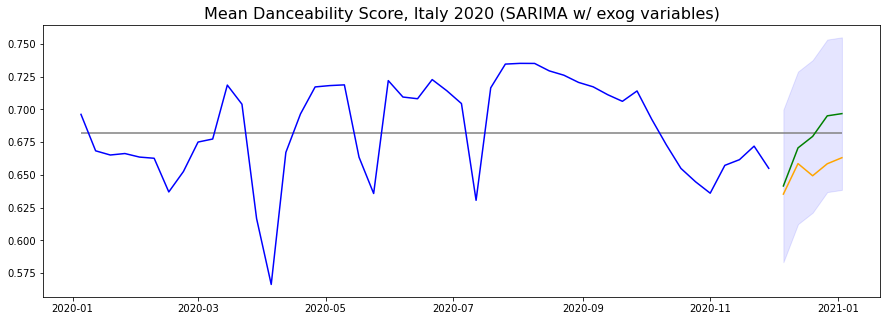

In [114]:
sarima_predict_plot_exog(it_rw_20, 'danceability', 2020, arima_param_df_20, exog_var=exog_danceability, title=f'Mean Danceability Score, Italy 2020 (SARIMA w/ exog variables)')

In [115]:
# for feature in five_features:
#     sarima_predict_plot_exog(it_rw_17, feature, 2020, exog_var=f'exog_{feature}', title=f'Mean {feature} Score, Italy 2020 (SARIMA w/ exog variables)')

d = 1
order = (4, 1, 0)
seasonal order = (1, 0, 1, 52)
Mode train RMSE (2020) - SARIMAX((1, 0, 1, 52)) w/ exogenous variables: 0.031877114720749965
Mode test RMSE (2020) - SARIMAX((1, 0, 1, 52)) w/ exogenous variables: 0.050936543557935504


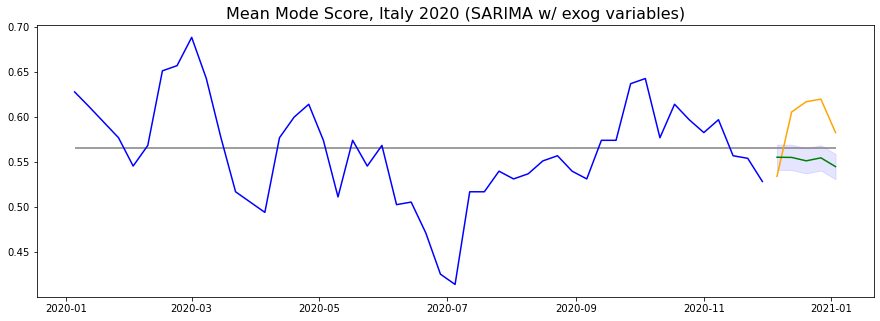

In [116]:
sarima_predict_plot_exog(it_rw_20, 'mode', 2020, arima_param_df_20, exog_var=exog_mode, title=f'Mean Mode Score, Italy 2020 (SARIMA w/ exog variables)')

d = 1
order = (1, 1, 1)
seasonal order = (1, 0, 2, 48)
Acousticness train RMSE (2020) - SARIMAX((1, 0, 2, 48)) w/ exogenous variables: 0.034244709414305595
Acousticness test RMSE (2020) - SARIMAX((1, 0, 2, 48)) w/ exogenous variables: 0.03504127736441988


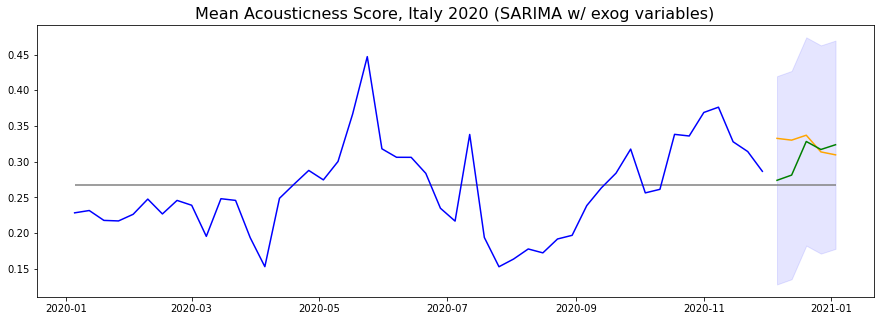

In [117]:
sarima_predict_plot_exog(it_rw_20, 'acousticness', 2020, arima_param_df_20, exog_var=exog_acousticness, title=f'Mean Acousticness Score, Italy 2020 (SARIMA w/ exog variables)')

d = 1
order = (0, 1, 0)
seasonal order = (0, 0, 1, 49)
Valence train RMSE (2020) - SARIMAX((0, 0, 1, 49)) w/ exogenous variables: 0.016683671431664136
Valence test RMSE (2020) - SARIMAX((0, 0, 1, 49)) w/ exogenous variables: 0.03100219586902646


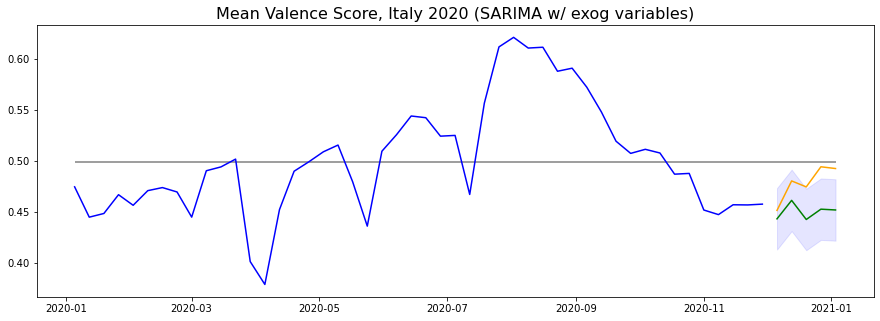

In [118]:
sarima_predict_plot_exog(it_rw_20, 'valence', 2020, arima_param_df_20, exog_var=exog_valence, title=f'Mean Valence Score, Italy 2020 (SARIMA w/ exog variables)')

d = 2
order = (0, 2, 1)
seasonal order = (2, 0, 0, 49)
Tempo train RMSE (2020) - SARIMAX((2, 0, 0, 49)) w/ exogenous variables: 1.831271723952204
Tempo test RMSE (2020) - SARIMAX((2, 0, 0, 49)) w/ exogenous variables: 2.867786721534822


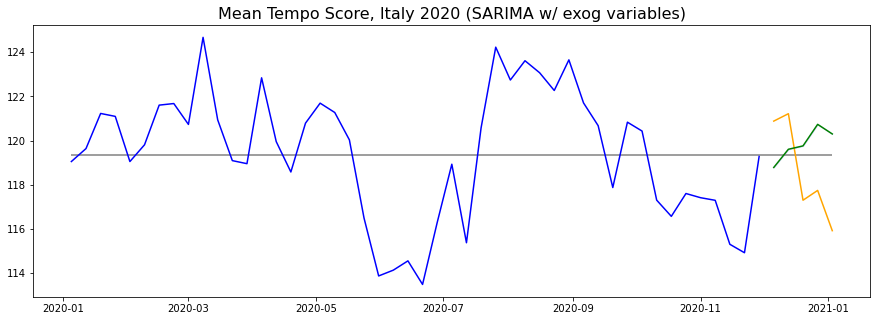

In [119]:
sarima_predict_plot_exog(it_rw_20, 'tempo', 2020, arima_param_df_20, exog_var=exog_tempo, title=f'Mean Tempo Score, Italy 2020 (SARIMA w/ exog variables)')

#### _Updated `arima_param_df_20`_

In [133]:
arima_param_df_20

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,sarima_train_rmse,sarima_test_rmse,exog_train_rmse,exog_test_rmse
0,danceability,1,2,2,"(2, 1, 2)","ARIMA(2,1,2)",-214.352402,0.029955,0.031795,"3, 0, 0, 48",0.029155,0.006303,0.017313,0.026653
1,mode,1,4,0,"(4, 1, 0)","ARIMA(4,1,0)",-187.656554,0.036004,0.054158,"1, 0, 1, 52",0.036034,0.046978,0.031877,0.050937
2,acousticness,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-170.836344,0.044908,0.031272,"1, 0, 2, 48",0.045349,0.035444,0.034245,0.035041
3,valence,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-208.242293,0.036157,0.040172,"0, 0, 1, 49",0.032651,0.026011,0.016684,0.031002
4,tempo,2,0,1,"(0, 2, 1)","ARIMA(0,2,1)",235.399507,2.298025,1.932611,"2, 0, 0, 49",2.298156,2.277815,1.831272,2.867787


#### _Pickling 2020 `arima_param_df_20` to compare with other years in another notebook_

In [134]:
arima_param_df_20.to_pickle('./metrics/2020_sarima_param_df.pkl')